<a href="https://colab.research.google.com/github/dubeyabhi07/hands-on-scikit-learn/blob/master/SVM/binarySVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Support vector Classification 

- SVM basics : https://towardsdatascience.com/understanding-support-vector-machine-part-1-lagrange-multipliers-5c24a52ffc5e

- Derivation & POC : https://www.youtube.com/watch?v=_PwhiWxHK8o 

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd


cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)

X_train, X_test, Y_train, Y_test = train_test_split(cancer_df, cancer.target, test_size=0.25, 
                                                    stratify=cancer.target, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

X_train.head(5)


train feature shape:  (426, 30)
test feature shape:  (143, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
218,19.800,21.56,129.70,1230.0,0.09383,0.13060,0.12720,0.08691,0.2094,0.05581,0.9553,1.186,6.487,124.40,0.006804,0.031690,0.03446,0.01712,0.01897,0.004045,25.73,28.64,170.30,2009.0,0.1353,0.3235,0.36170,0.18200,0.3070,0.08255
188,11.810,17.39,75.27,428.9,0.10070,0.05562,0.02353,0.01553,0.1718,0.05780,0.1859,1.926,1.011,14.47,0.007831,0.008776,0.01556,0.00624,0.03139,0.001988,12.57,26.48,79.57,489.5,0.1356,0.1000,0.08803,0.04306,0.3200,0.06576
431,12.400,17.68,81.47,467.8,0.10540,0.13160,0.07741,0.02799,0.1811,0.07102,0.1767,1.460,2.204,15.43,0.010000,0.032950,0.04861,0.01167,0.02187,0.006005,12.88,22.91,89.61,515.8,0.1450,0.2629,0.24030,0.07370,0.2556,0.09359
498,18.490,17.52,121.30,1068.0,0.10120,0.13170,0.14910,0.09183,0.1832,0.06697,0.7923,1.045,4.851,95.77,0.007974,0.032140,0.04435,0.01573,0.01617,0.005255,22.75,22.88,146.40,1600.0,0.1412,0.3089,0.35330,0.16630,0.2510,0.09445
152,9.731,15.34,63.78,300.2,0.10720,0.15990,0.41080,0.07857,0.2548,0.09296,0.8245,2.664,4.073,49.85,0.010970,0.095860,0.39600,0.05279,0.03546,0.029840,11.02,19.49,71.04,380.5,0.1292,0.2772,0.82160,0.15710,0.3108,0.12590


# Applying PCA
- Reducing to only 2 features for better visualisation.

In [2]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled=scaler.transform(X_test)

pca=PCA(n_components=2) 
pca.fit(X_train_scaled) 
X_train_pca=pca.transform(X_train_scaled)
pca.fit(X_test_scaled) 
X_test_pca=pca.transform(X_test_scaled)


pca_train_df = pd.DataFrame(X_train_pca, columns=['1st Comp', '2nd Comp'])
pca_test_df = pd.DataFrame(X_test_pca, columns=['1st Comp', '2nd Comp'])
pca_train_df.head(5)

,1st Comp,2nd Comp
0,4.769821,-2.646802
1,-3.286009,0.145666
2,-0.916999,2.463817
3,3.577654,-0.941917
4,7.187707,12.444114


# Applying SVC and LinearSVC

### basic differences between SVC and LinearSVC

- LinearSVC doesn't accept kernel parameter, it is assumed to have linear kernel.

- LinearSVC is not equivalent to SVC with linear kerner as it minimizes squared hinge loss, while SVC minimizes hinge loss.

- LinearSvc performs somewhat better than svc with linear kernel, if data in linear
- By setting loss function = hinge and fit_intercept = false (after normalising and centering the data), linearSvc becomes almost equivalent to svc.

In [3]:
svc = svm.SVC(kernel='linear', C=1)
svc.fit(pca_train_df, Y_train)
print(svc)

linearSvc = svm.LinearSVC(C=1,max_iter=10000)
linearSvc.fit(pca_train_df,Y_train)
print(linearSvc)

linearSvc2 = svm.LinearSVC(C=1,max_iter=10000,loss = 'hinge',fit_intercept = "false")
linearSvc2.fit(pca_train_df,Y_train)
print(linearSvc2)

print("----------------------------------------------------------------------------")
y_pred_svc= svc.predict(pca_test_df)
print(metrics.accuracy_score(Y_test, y_pred_svc))

y_pred_linearSvc= linearSvc.predict(pca_test_df)
print(metrics.accuracy_score(Y_test, y_pred_linearSvc))

y_pred_linearSvc2= linearSvc2.predict(pca_test_df)
print(metrics.accuracy_score(Y_test, y_pred_linearSvc2))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept='false',
          intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)
----------------------------------------------------------------------------
0.965034965034965
0.9790209790209791
0.965034965034965


# Ploting decision boundries in 2D :

In [4]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plotBoundry(X_test,Y_test,clf,dim) : 

  X0, X1 = X_test[:, 0], X_test[:, 1]
  xx, yy = make_meshgrid(X0, X1)
  Y_target_list = Y_test.tolist()
  yl1= [int(target1) for target1 in Y_target_list]
  cdict1={0:'lime',1:'blue'}
  labels1=yl1

  global ax
  global fig
  
  labl1={0:'Malignant',1:'Benign'}
  marker1={0:'x',1:'x'}
  alpha1={0:.8, 1:0.5}
  if(dim==3):
    fig, ax = plt.subplots(figsize=(12,12))
    ax = plt.axes(projection='3d')
    Z = clf.decision_function(np.c_[X0,X1])
    Z_support = clf.decision_function(np.c_[clf.support_vectors_[:, 0],clf.support_vectors_[:, 1]])
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],Z_support, s=50, color='black', label='Support Vectors')
    for l1 in np.unique(labels1):
      ix1=np.where(labels1==l1)
      ax.scatter(X0[ix1],X1[ix1],Z[ix1], c=cdict1[l1],label=labl1[l1],s=40,marker=marker1[l1],alpha=alpha1[l1])
  else:
    fig, ax = plt.subplots(figsize=(7,7))
    for l1 in np.unique(labels1):
      ix1=np.where(labels1==l1)
      ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=40,marker=marker1[l1],alpha=alpha1[l1])
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=40, color='black', label='Support Vectors')
  
  plot_contours(ax,clf, xx, yy,cmap='seismic', alpha=0.6)

  plt.legend(fontsize=8)
  plt.xlabel("1st Principal Component",fontsize=10)
  plt.ylabel("2nd Principal Component",fontsize=10)

  plt.show()

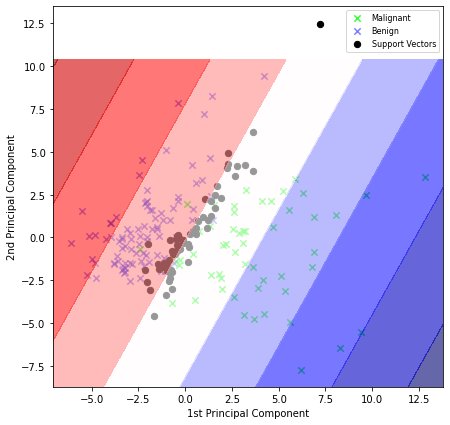

In [5]:
plotBoundry(X_test_pca,Y_test,svc,2)

# Kernel trick :

- For linearly non-separable data, we can projects the data points into another dimention using kernels (eg. radio,polynomial,sigmoid etc).

- Using this technique for above data, despite the fact that above data looks linearly separable.

(87, 2)


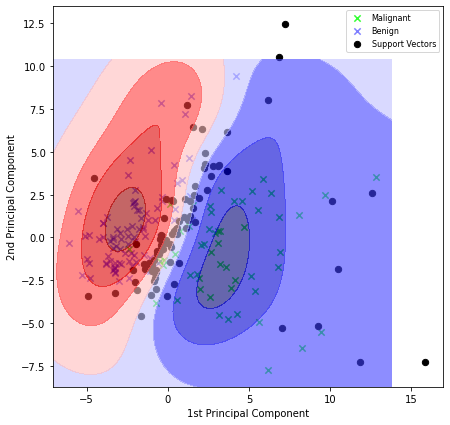

In [6]:
svcRbf = svm.SVC(kernel='rbf', C=1)
svcRbf.fit(pca_train_df, Y_train)
print(svcRbf.support_vectors_.shape)
plotBoundry(X_test_pca,Y_test,svcRbf,2)

(65, 2)


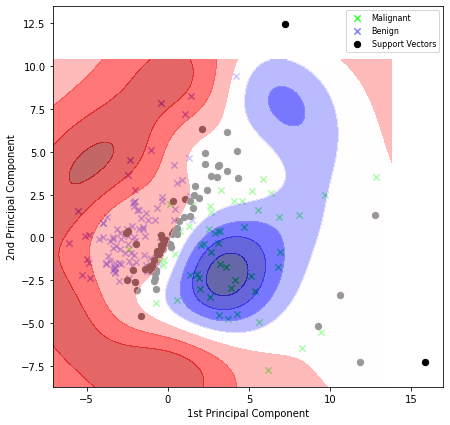

In [7]:
svcRbf2 = svm.SVC(kernel='rbf', C=1000)
svcRbf2.fit(pca_train_df, Y_train)
print(svcRbf2.support_vectors_.shape)
plotBoundry(X_test_pca,Y_test,svcRbf2,2)

# Ploting decision boundries in 3D :

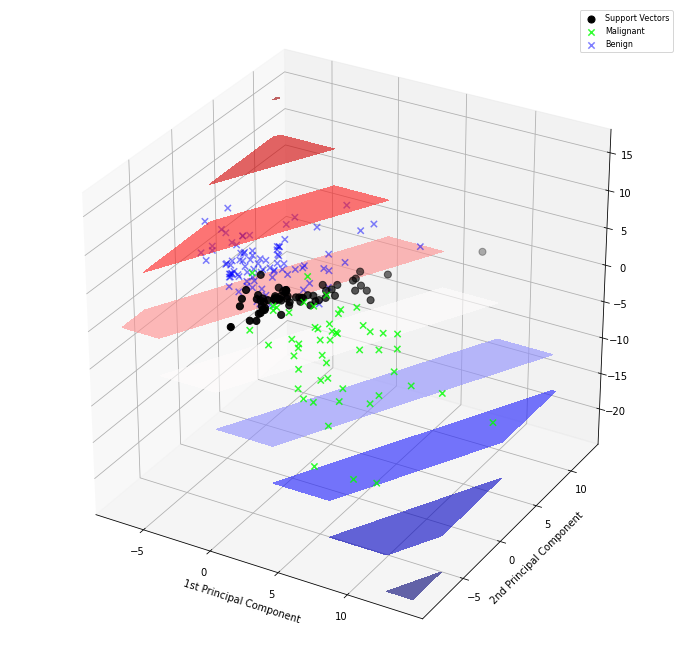

In [8]:
plotBoundry(X_test_pca,Y_test,svc,3)


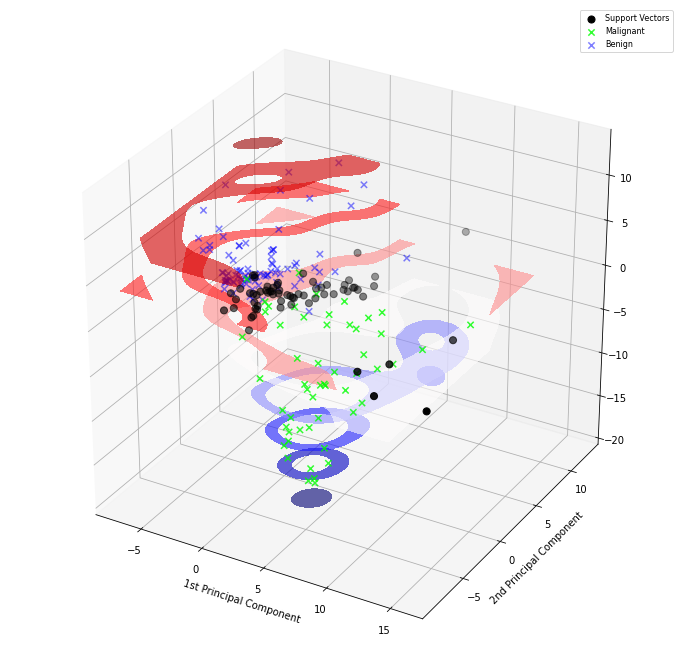

In [9]:
plotBoundry(X_test_pca,Y_test,svcRbf2,3)

https://stackoverflow.com/questions/9480605/what-is-the-relation-between-the-number-of-support-vectors-and-training-data-and